# **ANN Example: House Price Prediction using Perth Housing dataset**

Let us implement a simple **Artificial Neural Network (ANN)** step-by-step using the dataset for Perth housing. The aim of this notebook is to build a Neural Network model that can predict housing prices in *Perth* (located in Western Australia) based on a set of scrapped features made available in the [Perth Housing Dataset](https://www.kaggle.com/datasets/syuzai/perth-house-prices) on **Kaggle**.

For the purpose of this implementation, we will use **TensorFlow/Keras**. We will cover the entire process from importing data to cleaning the data, model building to training and evaluation, along with hyperparameter tuning.

### **Step 1: Install the required libraries.**

If not already installed we need to install `tensorflow` by running the below command in the bash terminal:<br>
`pip install tensorflow`

### **Step 2: Import Necessary Libraries**

First we will import all the necessary libraries that we are going to use in our code.

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cmap = sns.diverging_palette(220, 10, as_cmap=True)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

import warnings
warnings.filterwarnings('ignore')

### **Step 3: Importing the dataset**

Let us import the dataset. For this notebook, we have the dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/syuzai/perth-house-prices) and extracted the `csv` file to the same directory where the notebook is.

If you have the file present in any other directory, pass that directory path as a *string* parameter to the `pd.read_csv()` function in the below code cell.

In [2]:
df_perth = pd.read_csv('all_perth_310121.csv')
print(df_perth.columns)
df_perth.head(2)

Index(['ADDRESS', 'SUBURB', 'PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE',
       'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN',
       'NEAREST_STN_DIST', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE',
       'NEAREST_SCH', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')


,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.19347,115.859554,ATWELL COLLEGE,5.524324,129.0


### **Step 4: Preprocessing and cleaning the dataset**

Now we wil preprocess and clean the dataset for later use. Specifically, we will drop unnecessary columns, remove null values.

In [3]:
# Drop the column 'NEAREST_SCH_RANK' as it may change over time.
# We will give more importance to the presence of a school nearby rather than its rank.
df_perth = df_perth.drop(['NEAREST_SCH_RANK'], axis=1)

print(df_perth.isna().sum())

ADDRESS                0
SUBURB                 0
PRICE                  0
BEDROOMS               0
BATHROOMS              0
GARAGE              2478
LAND_AREA              0
FLOOR_AREA             0
BUILD_YEAR          3155
CBD_DIST               0
NEAREST_STN            0
NEAREST_STN_DIST       0
DATE_SOLD              0
POSTCODE               0
LATITUDE               0
LONGITUDE              0
NEAREST_SCH            0
NEAREST_SCH_DIST       0
dtype: int64


As we can see there are lots of `NaN` values specifically in the columns `GARAGE` and `BUILD_YEAR`. While filling the missing values in `GARAGE` with median values makes sense, that may not be the right approach for `BUILD_YEAR` column as that may affect the model performance and accuracy. So for the time being, we will just drop those rows with missing values in `BUILD_YEAR` column.

In [4]:
df_perth['GARAGE'].fillna(df_perth['GARAGE'].median(), inplace=True)
df_perth = df_perth.dropna(subset=['BUILD_YEAR'])
df_perth = df_perth.reset_index(drop=True)

Now we process the `DATE_SOLD` variable to convert it to a `datetime` format and extract relevant components like month, year etc.

In [5]:
df_perth['DATE_SOLD'] = df_perth['DATE_SOLD'].str.strip()
df_perth['DATE_SOLD'] = pd.to_datetime(df_perth['DATE_SOLD'], format='%m-%Y', errors='coerce')

df_perth['YEAR_SOLD'] = df_perth['DATE_SOLD'].dt.year
df_perth['MONTH_SOLD'] = df_perth['DATE_SOLD'].dt.month

We can also check the distribution of the target variable `PRICE`.

<Axes: xlabel='PRICE', ylabel='Density'>

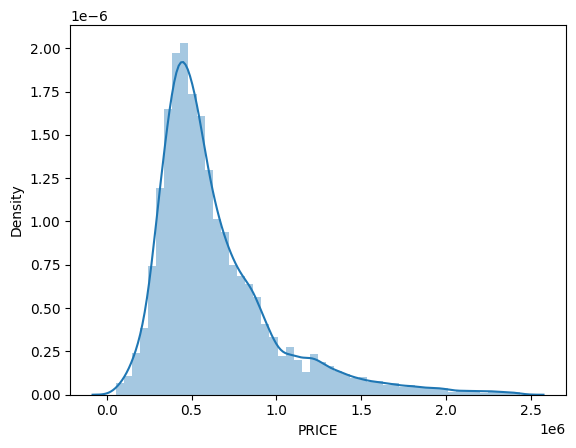

In [6]:
sns.distplot(df_perth['PRICE'])

We can also see the correlation between the features and target - just to have a better idea about the dataset!

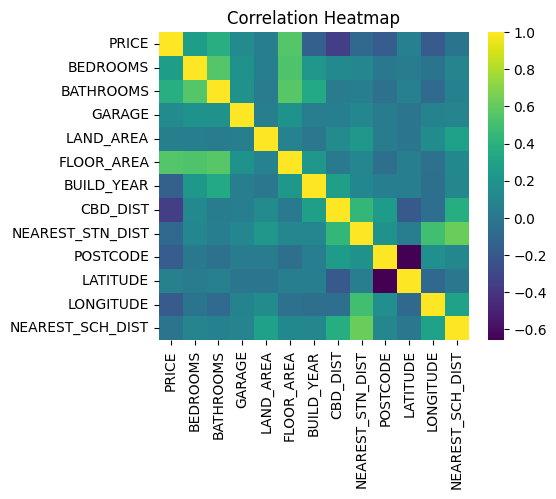

In [9]:
plt.figure(figsize=(5, 4))
sns.heatmap(df_perth.select_dtypes(include=['float64', 'int64']).corr(), cmap="viridis")
plt.title('Correlation Heatmap')
plt.show()

Now we will separate the numerical and categorical variables and then create a pipeline to one-hot encode the categorical variables.

In [10]:
categorical_features = ['SUBURB', 'NEAREST_STN', 'NEAREST_SCH', 'POSTCODE']
numerical_features = [
    'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA',
    'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'NEAREST_SCH_DIST',
    'LONGITUDE', 'LATITUDE', 'YEAR_SOLD', 'MONTH_SOLD'
]

# One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

Finally we drop all the columns that are no more required for model building and update the **features** and **targets**.

In [11]:
X = df_perth.drop(columns=['PRICE', 'ADDRESS', 'DATE_SOLD'])
y = df_perth['PRICE']

### **Step 5: Train / Test Split and Preprocessing Pipeline**

Now, we split the dataset into train and test. We also pass the `X`(features) through the preprocessing pipeline that we just created.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### **Step 6: Build the ANN model**

Now, we finally create our Neural Network model.

In [13]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),                                                 # Regularization to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)                                                      # Output layer: Single neuron for regression
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,769 (378.00 KB)

 Trainable params: 96,769 (378.00 KB)

 Non-trainable params: 0 (0.00 B)

**Explanation of Different Layers**

- **Input Layer**:
  - This layer simply holds the input data, preparing it for subsequent layers.
<br><br>
- **Dense Layer 1**:
  - `None` means the batch_size is flexible.
  - `128` indicates that this layer has $128$ units (or neurons).
  - Tota number of parameters: `total parameter = input_units * output_units + output_units (for bias)`. Here since, `X_train.shape` returns `(24400, 674)`, there are total `674` inputs. So, the total parameter count is `(674 * 128) + 128 = 86,400`
  - `ReLU` (Rectified Linear Unit) activation function is used to introduce non-linearity into the model
<br><br>
- **Dropout Layer 1**:
  - $30%$ of the neurons in the previous layer will be randomly "dropped" or set to zero during each training iteration. This is a regularization technique used to help the model generalize better by forcing it not to rely too much on any particular neuron and thus preventing overfitting.
<br><br>
- **Dense Layer 2**:
  - Has `64` output neurons
  - Total parameter count: `(128 * 64) + 64 = 8,256`
  - `ReLU` activation function is used to introduce non-linearity
<br><br>
- **Dropout Layer 2**:
  - Same as *Dropout Layer 1*: 20% of the neurons from the previous layer will be randomly "dropped" or set to zero during each training iteration to prevent overfitting.
<br><br>
- **Dense Layer 3**:
  - Has `32` output neurons
  - Total parameter count: `(64 * 32) + 32 = 2,080`
  - `ReLU` activation function is used to introduce non-linearity
<br><br>
- **Output Layer**:
  - Single output neuron, since we are predicting a value here
  - Total parameter count: `(1 * 32) + 1 = 33`
  - No activation function is used, which implies a linear activation function. This is typical for regression tasks, where you are predicting a continuous value (like house prices or stock prices).
<br><br>

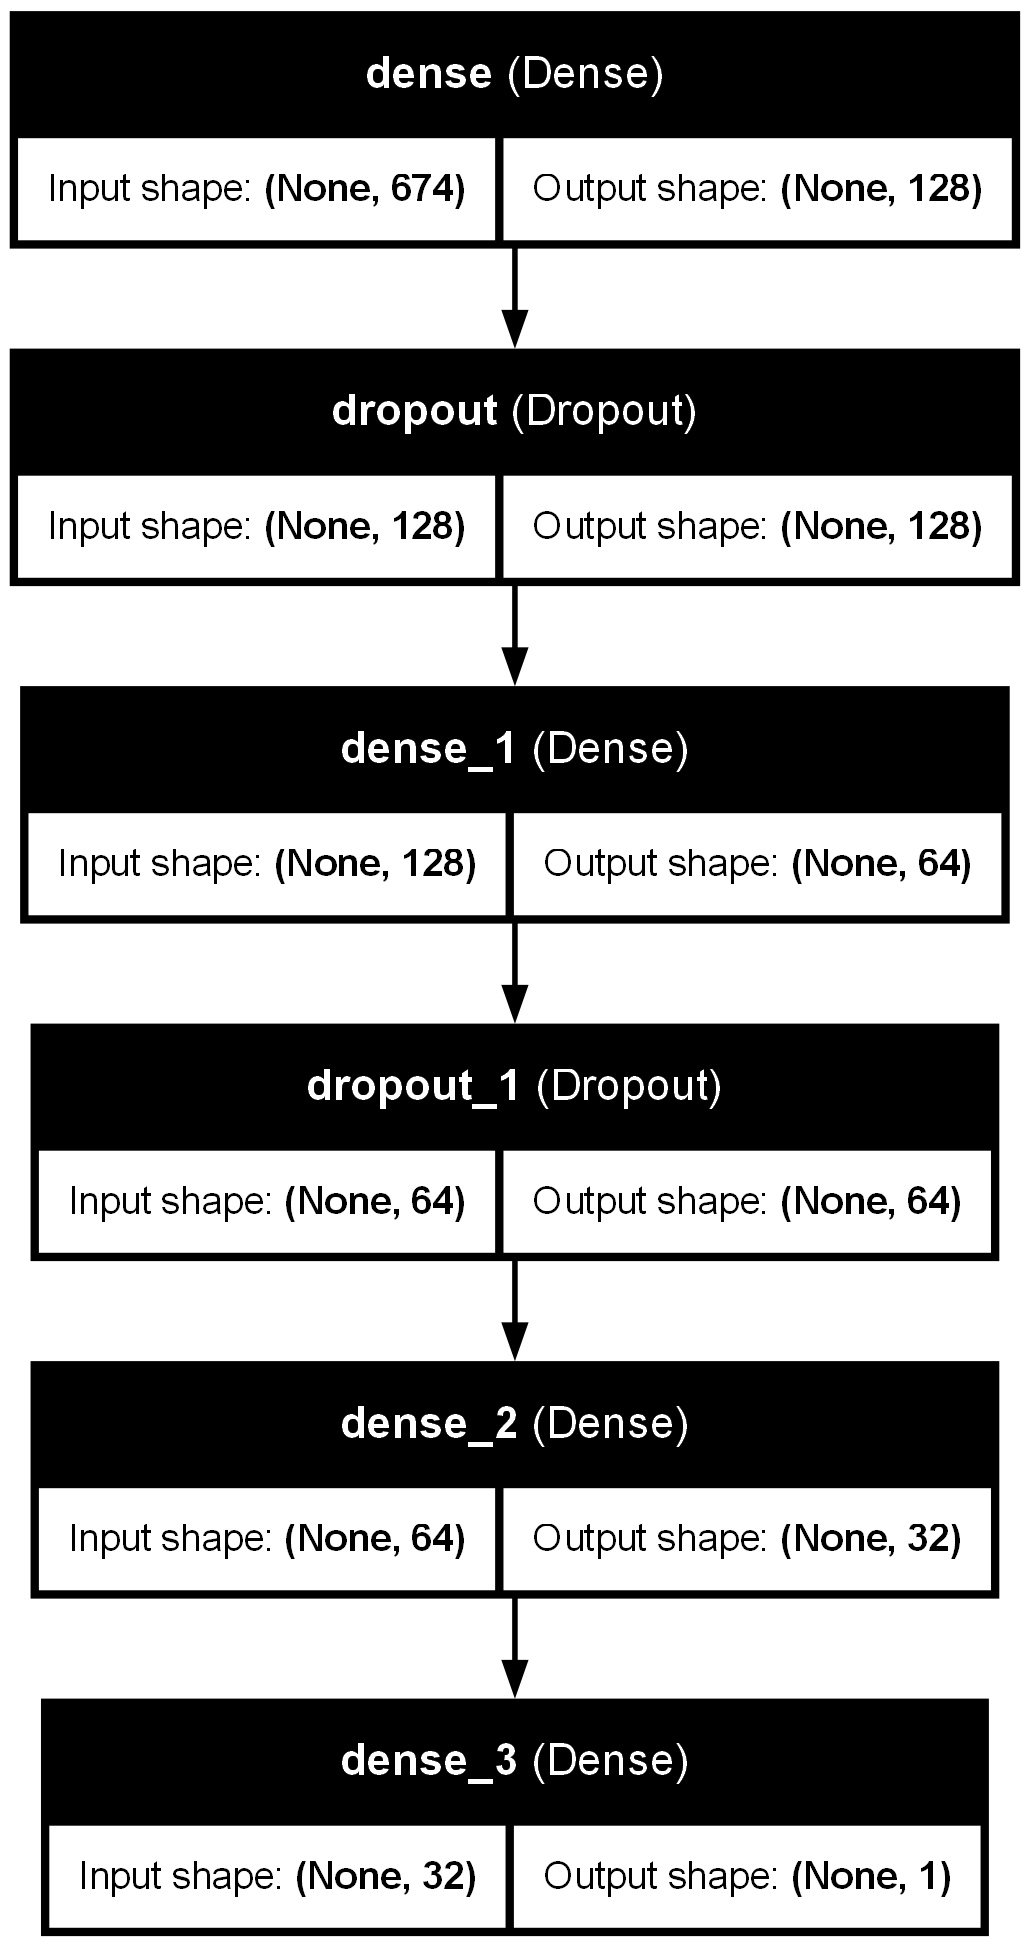

In [14]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
plot_model(model, to_file='ann_example_house_price_prediction_model_plot.png', show_shapes=True, show_layer_names=True)

### **Step 7: Compile the model**

After building the model, we need to compile it. The compile step specifies the optimizer, loss function, and metrics to evaluate during training.

In [15]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

### **Step 8: Train the model**

Now let's train the model on the training data.

In [16]:
epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
print("The model has successfully trained")

Epoch 1/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 456976072704.0000 - mae: 571846.3750 - val_loss: 59351998464.0000 - val_mae: 166969.7188
Epoch 2/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 57983848448.0000 - mae: 159330.8281 - val_loss: 38863503360.0000 - val_mae: 127319.5781
Epoch 3/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 43650211840.0000 - mae: 137324.5469 - val_loss: 33692610560.0000 - val_mae: 116078.4375
Epoch 4/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 37254455296.0000 - mae: 126788.8203 - val_loss: 31270938624.0000 - val_mae: 110903.2969
Epoch 5/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 34775932928.0000 - mae: 122588.8594 - val_loss: 29926758400.0000 - val_mae: 108131.6016
Epoch 6/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 33584799744.0000 - mae: 120804.8594 - val_loss: 29170634752.0000 - val_mae: 107032.6719
Epoch 7/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 33540562944.0000 - mae: 121111.7031 - val_loss: 285

**HOW `epochs` AND `batch_size` IMPACT THE PERFORMANCE?**

**EPOCHS**
<br>An epoch is one complete pass of the entire training dataset through the model. During training, the weights are updated after every batch in each epoch.

**How `epochs` impact performance**:

- **Too few epochs**:
    - The model may **underfit** because it doesn’t have enough opportunities to learn patterns from the data.
    - The training and validation losses will not converge, and the accuracy will be low.
- **Too many epochs**:
    - The model may **overfit** the training data, meaning it performs well on the training set but poorly on unseen data.
    - Validation loss may start increasing even as training loss decreases.

**How to choose right number of `epochs`**:

- Monitor the **training and validation loss**:
    - If the validation loss stops improving or starts increasing, the training should be stopped. This is called **early stopping**.
- Use **Cross-Validation**:
    - Split the training data into training and validation subsets to observe the performance on unseen data during training.
- **Empirical Values**:
    - For small datasets like MNIST, 10–30 epochs are often sufficient. For more complex datasets, the number may range from 50 to 100 or more.
 
**BATCH SIZE**
<br>The batch size is the number of training samples processed before the model's internal parameters (weights) are updated.

**How `batch_size` impact performance**:

- **Small batch size (e.g., 8, 16)**:
    - More frequent weight updates, leading to a more dynamic learning process. (+)
    - Helps escape local minima in the loss landscape due to noisy gradients. (+)
    - Requires less memory, making it suitable for GPUs with limited memory. (+)
    - Training can be slow due to frequent updates. (-)
    - Noisy updates may prevent the model from converging to the global minimum. (-)
- **Large Batch Size (e.g., 64, 128, or more)**:
    - More stable and precise gradient estimates, leading to smoother convergence. (+)
    - Faster training since fewer updates are required per epoch. (+)
    - Requires more memory, making it challenging for larger networks and high-resolution inputs. (-)
    - May get stuck in sharp local minima, reducing generalization ability. (-)

**How to choose right `batch_size`**:

- **Hardware limitations**:
    - Large batch sizes (e.g., 128, 256) require GPUs with more memory.
    - On limited hardware, start with small sizes (e.g., 32 or 64).
- **Dataset size**:
    - For small datasets, smaller batch sizes often work better.
    - For large datasets, larger batch sizes may speed up training without sacrificing performance.
- **Empirical Rules**:
    - A common starting point is `32` or `64`, but this should be fine-tuned based on the problem.

**COMBINED IMPACT OF EPOCHS AND BATCH SIZE**

- **Training Time**:
    - Smaller batch sizes require more updates per epoch, increasing training time.
    - Larger batch sizes speed up training but require more GPU memory.
- **Model Performance**:
    - Too few epochs or too small a batch size may result in underfitting.
    - Too many epochs or too large a batch size may lead to overfitting or poor generalization.

**PRACTICAL TIPS**
1. **Start with Standard Values**: Begin with batch sizes of `32` or `64`, and train for `10 - 30` epochs.
2. **Experiment**: Use different batch sizes (e.g., 32, 64, 128) and epochs while monitoring the loss and accuracy.
3. **Early Stopping**: Use early stopping to avoid overfitting by stopping training when validation performance stops improving.
4. **Learning Rate**: Adjust the learning rate when changing the batch size. A smaller batch size might require a smaller learning rate and vice versa.

**TOTAL NUMBER OF WEIGHT UPDATES**

If the dataset contains $N$ samples and the batch size is $32$, the weights will be updated $N/32$ times per epoch.
<br>Over $10$ epochs, the total number of weight updates will be:

$$\text{Total updates} = \frac{N}{32} \times 10$$

For example, if $N = 10,000$, there will be $\frac{10,000}{32} \times 10 = 3,125$ updates in total per weight. That is, each weights will be updated $3,125$ times. So,

$$\text{Total weight updates} = 3,125 \times \text{Number of weights in the model}$$

### **Step 9: Evaluate the model**

After training, we can evaluate the model using the test data to see how well it performs.

In [17]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error on Test Data: {mae}")

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23832256512.0000 - mae: 96040.3672 
Mean Absolute Error on Test Data: 98602.6015625


As we can see, we have received a Mean Absolute Error of `~$98,600`, while the actual price of the houses ranges from `$52,000` to `$2,440,000` with a mean value of `~$638,614`. We would say, that is a reasonable error. But we can always, experiment with tuning the hyperparameters (`epochs`, `batch_size`) or using different optimizer other than `adam` or adding more layers in the architecture of neural network to make it learn and predict relatively more accurate result.

### **Step 10: Save the model**

We can also save the model using any name of our choice.

In [18]:
model.save('ann_example_house_price_prediction_model.keras')
print("Saving the model as house_price_prediction_model.keras")

Saving the model as house_price_prediction_model.keras


### **Step 11: Plotting the training history**

It’s helpful to visualize the training process to understand how the model is improving over time.

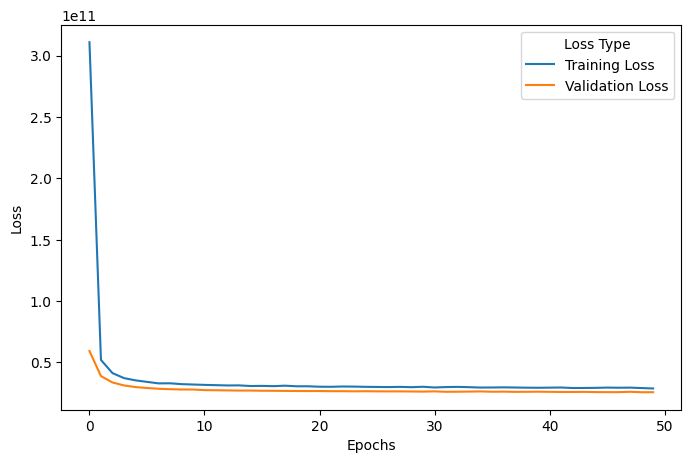

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.show()